\begin{equation*}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Nor}{\mathcal{N}}
\end{equation*}




# Due Dates

* Textbook: None
* Coding: Tuesday, December 11, at 11:59 PM





In [1]:
# This is code to load the assignment.
# You'll need to run this code do or restart the assignment.
from loadAssignment import loadAssignment
Assignment, Questions, Submit, Data = loadAssignment(11)

# These are modules that we need
# once you run this code, you don't need to load them again
import autograd.numpy as np
import autograd as ag
import scipy.linalg as la
import numpy.linalg as nla
import scipy.signal as sp
import scipy.stats as st
import numpy.random as rnd
import matplotlib.pyplot as plt
%matplotlib inline



# Question 0



In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/zMa3gUaVibQ" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


The first few problems in this homework will focus on coding the Kalman smoother. The particular algorithm is known as the RTS smoother, and is presented in Table 5.2 of the book.



As discussed in the video lecture, the smoother requires first computing all of the means and covariances for the Kalman filter.

Assume that we have a linear dynamical model of the form:

\begin{align*}
x_{k=1} &= \Phi x_k + w_k \\
y_k &= H x_k + v_k,
\end{align*}

where $x_0\sim \Nor(\hat x_0^-,P_0^-)$ and the noises are independent with distributions given by
$w_k\sim \Nor(0,Q)$ and $v_k\sim \Nor(0,R)$.

The observed data, $y_k$ is given by the array of values below.



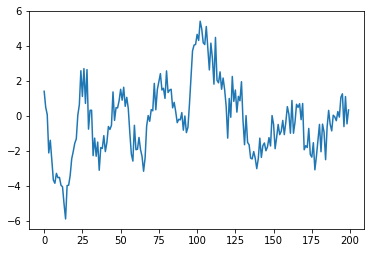

In [3]:
Y = Data.Y
Time = Data.Time
plt.plot(Time,Y)


The system matrices are given by:



In [4]:
Phi = np.array([[0.9, -0.18],
[0.18, 0.9]])

H = np.array([[1, 0]])

Q = np.array([[0.01, 0],
[0, 1]])

R = np.array([[0.5]])

xhat0_prior = np.array([1, 2])

P0_prior = np.array([[2, 0],
[0, 1]])


Compute all of the mean and covariances from the Kalman filter. Specifically, compute 

```
Xhat_prior, P_prior, Xhat_post, P_post
```

Here if $T$ is the number of measurements from $Y$, and $n$ is the dimension of $x$, the arrays should be:

* `Xhat_prior` an $T\times n$ array or prior means: `Xhat_prior[k]` is $\hat x_k^-$
* `P_prior` is an $T\times n\times n$ array of prior covariances: `P_prior[k]` is $P_k^-$
* `Xhat_post` is an $T\times n\times n$ array of posterior means: `Xhat_post[k]` is $\hat x_k^+$
* `P_post` is an $T\times n\times n$ array of posterior covariances: `P_post[k]` is $P_k^+$

Note: You will use this calculation repeately for different system matrices. So, it may be helpful for the rest of the 
homework to code this calculation as a function that takes the system matrices and the measurements and computes the arrays above. 
(The DRY (don't repeat yourself) principle) 



Spot on.
A score of 1 was entered for Question 0


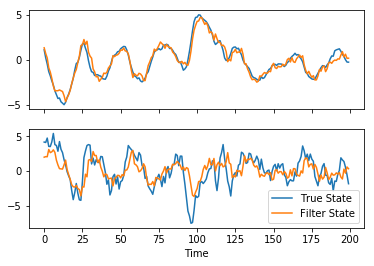

In [5]:
def filterSignal(Phi,H,Q,R,x0_pre,P0_pre,Y):

    Xhat_pre = []
    Xhat_post = []
    P_pre = []
    P_post = []



    xhat = np.copy(x0_pre)
    P = np.copy(P0_pre)

    logLik = 0.
    for y in Y:
        Xhat_pre.append(xhat)
        P_pre.append(P)
    
        Psi = H @ P @ H.T + R
        
        res = y - H@xhat
        logLik += st.multivariate_normal.logpdf(y,mean=H@xhat,cov=Psi)
        
        K = la.solve(Psi,H @ P).T
        xhat = xhat + K @ (y - H @ xhat)
        P = P - K @ Psi @ K.T
    
        Xhat_post.append(xhat)
        P_post.append(P)
    
    
        xhat = Phi @ xhat
        P = Q + Phi @ P @ Phi.T

    P_pre = np.array(P_pre)
    P_post = np.array(P_post)
    Xhat_pre = np.array(Xhat_pre)
    Xhat_post = np.array(Xhat_post)
    return Xhat_pre,P_pre,Xhat_post,P_post,logLik

Xhat_prior,P_prior,Xhat_post,P_post,logLike = \
filterSignal(Phi,H,Q,R,xhat0_prior,P0_prior,Y)

Questions[0].checkAnswer(Xhat_prior,P_prior,Xhat_post,P_post)


# Question 1

In the later parts of the homework, we will use the Expectation-Maximization (EM) algorithm to learn the system matrices. 
The EM algorithm is a fancy way of doing maximum likelihood when there are hidden variables. IN this case, the state $x_k$ are hidden variables.

To assess the performance of the EM algorithm, we will need to evaluate the log likelihood of the measurements: $\log p(y_0,y_1,\ldots,y_{T-1})$.

COmpute the log-likelihood of the measurements. Hint: it can be efficiently computer from the Kalman filter by appropriately splitting the joint density, $p(y_0,y_1,\ldots,y_{T-1})$ 
into terms that can be computer by filters.



In [6]:
Questions[1].checkAnswer(logLike)

Hoorah!
A score of 1 was entered for Question 1



# Question 2



In [7]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/-3B5ixDVgvA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



Now that we have all of the matrices from the Kalman filter, we can compute the Kalman smoother via:
\begin{align*}
\hat x_{T-1}^s &= \hat x_{T-1}^+ \\
P_{T-1}^s &= P_{T-1}^+
\end{align*}
and for $k < T-1$:
\begin{align*}
G_k &= P_k^+ \Phi^\top (P_{k+1}^-)^{-1} \\
\hat x_k^s &= \hat x_k^+ + G_k(\hat x_{k+1}^s - \hat x_{k+1}^-) \\
P_k^s &= P_k^+ + G_k(P_{k+1}^s - P_{k+1}^-)G_k^\top
\end{align*}

Calculate array `Xhat_s`, `P_s`, and `G_s` such that:
* `Xhat_s` is a $T\times n$ array of smoother means: `Xhat_s[k]` is $\hat x_k^s$
* `P_s` is a $T\times n\times n$ array of smoother covariances: `P_s[k]` is $P_k^s$
* `G_s` is a $(T-1)\times n\times n$ array of smoother gains: `G_s[k]` is $G_k$

As before, it would help to make this computation a function, as you will need to use these calculations again.
The DRY principle says it would be good to code it up as a function.



That is correct. Nice.
A score of 1 was entered for Question 2


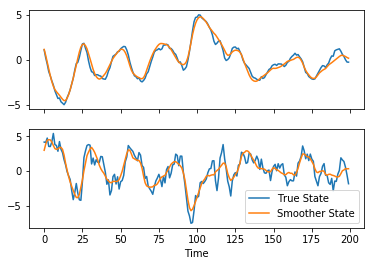

In [8]:
def smoothSignal(Phi,H,Q,R,x0_pre,P0_pre,Y):
    Xhat_pre,P_pre,Xhat_post,P_post,logLik = \
    filterSignal(Phi,H,Q,R,x0_pre,P0_pre,Y)

    P = np.copy(P_post[-1])
    xhat = np.copy(Xhat_post[-1])

    Xhat_s = [xhat]
    P_s = [P]
    G_s = []
    
    NumSteps = len(Y)

    for k in range(NumSteps-1)[::-1]:
        P_cur = P_post[k]
        P_next = P_pre[k+1]
    
        x_cur = Xhat_post[k]
        x_next = Xhat_pre[k+1]
    
        G = la.solve(P_next,Phi @ P_cur).T
    
        G_s.append(G)
        xhat = x_cur + G @ (xhat - x_next)
        P = P_cur + G @ (P-P_next) @ G.T
    
        Xhat_s.append(xhat)
        P_s.append(P)
        
    Xhat_s = np.array(Xhat_s[::-1])
    P_s = np.array(P_s[::-1])
    G_s = np.array(G_s[::-1])
    return Xhat_s, P_s, G_s,logLik


Xhat_s,P_s,G_s,logLik = smoothSignal(Phi,H,Q,R,xhat0_prior,P0_prior,Y)


Questions[2].checkAnswer(Xhat_s,P_s,G_s)


What you should see is that, compared to the filter, the result of the smoother is significantly... smoother.
It is also more accurate. This is because it is using ALL of the data to estimate the state, 
not just the data up to the current point in time.




# Question 3



In [9]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/mIvnNliaLWk" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


The rest of the homework will focus on identifying the system matrices via the EM algorithm. 

As discussed in the video lecture, the EM algorithm alternates between 
* E-Step: $J(\theta|\theta_i) = \E[\log p(X,Y|\theta) | \theta_i,Y]$ 
* M-step: $\theta_{i+1} = \textrm{argmax}_{\theta} J(\theta| \theta_i)$

Here $\theta = (\Phi,H,Q,R,\hat x_0^-,P_0^-)$

Let $X = x_{0:T-1}$ and $Y = y_{0:T-1}$. 

As we saw, the E-step can be computed analytically. Indeed, the log-likelihood has the form:
\begin{align*}
\log p(X,Y|\theta) &= \log p(x_0|\theta) + \sum_{k=0}^{T-2} \log p(x_{k+1}|x_k,\theta) + \sum_{k=0}^{T-1} \log p(y_k|x_k,\theta) \\
&= -\frac{1}{2}\left((x_0-\hat x_0^-)(P_0^-)^{-1}(x_0-\hat x_0) +\log\det P_0^-\right) \\
& -\frac{1}{2} \sum_{k=0}^{T-2} \left((x_{k+1}-\Phi x_k)^\top Q^{-1} (x_{k+1}-\Phi x_k) + \log\det Q\right) \\
& -\frac{1}{2} \sum_{k=0}^{T-1} \left((y_{k}-H x_k)^\top R^{-1}(y_k-H x_k) + \log\det R\right)
\end{align*}
And the correspnding means can be computed via the Kalman smoother:

\begin{equation*}
\newcommand{\Tr}{\mathrm{Tr}}
\end{equation*}
\begin{align*}
\E[(x_0-\hat x_0^-)^\top (P_0^{-})^{-1}(x_0-\hat x_0^-)|Y] 
&= 
\Tr((P_0^{-1})^{-1}(P_0^s + (\hat x_0^s-\hat x_0^-)(\hat x_0^s-\hat x_0^-)^\top))\\
\E[(y_k-H x_k)^\top R^{-1} (y_k - H_k)] &=
\Tr(R^{-1}(HP_k^s H^\top + (H x_k^s - y_k)(H \hat x_k^s - y_k)^\top)) \\
\E[(x_{k+1}-\Phi x_k)^\top Q^{-1} (x_{k+1}-\Phi x_k)]&= \\
&
\hspace{-10em}
\Tr\left(
Q^{-1}\left(
\begin{bmatrix}
-\Phi & I
\end{bmatrix}
\left(
\begin{bmatrix}
P_k^s & G_k P_{k+1}^s \\
P_{k+1}^s G_k^\top & P_{k+1}^s
\end{bmatrix}
+\begin{bmatrix}
\hat x_k^s \\
\hat x_{k+1}^s
\end{bmatrix}
\begin{bmatrix}
\hat x_k^s \\
\hat x_{k+1}^s
\end{bmatrix}^\top
\right)
\begin{bmatrix}
-\Phi^\top \\
I
\end{bmatrix}
\right)
\right)
\end{align*}

As discussed in the video, the initial condition terms can be optimized by setting 
\begin{align*}
\hat x_0^- & =\hat x_0^s \\
P_0^- &= P_0^s
\end{align*}

The measurement term can be expressed as:

\begin{multline}
\sum_{k=0}^{T-1}\Tr(R^{-1}(HP_k^s H^\top + (H x_k^s - y_k)(H \hat x_k^s - y_k)^\top)) = 
\\
= \sum_{k=0}^{T-1}\Tr(R^{-1}(H(P_k+\hat x_k^s \hat x_k^s)H^\top -y_k (\hat x_k^s)^\top H^\top - H (x_k^s) y_k^\top + y_k y_k^\top)) \\
= \Tr(R^{-1}(H\Sigma H^\top + N H^\top + H N^\top + F))
\end{multline}
for some matrices, $\Sigma$, $N$, and $F$. 

Based on the theory discussed in the video, the optimal $H$ and $R$ can be computed as:
\begin{align*}
H &= -N\Sigma^{-1} \\
R &= (H\Sigma H^\top + N H^\top + H N^\top + F) / T
\end{align*}

Finally, the update step terms can be expressed as:
\begin{multline}
\sum_{k=0}^{T-2}\Tr\left(
Q^{-1}\left(
\begin{bmatrix}
-\Phi & I
\end{bmatrix}
\left(\begin{bmatrix}
P_k^s & G_k P_{k+1}^s \\
P_{k+1}^s G_k^\top & P_{k+1}^s
\end{bmatrix}
+\begin{bmatrix}
\hat x_k^s \\
\hat x_{k+1}^s
\end{bmatrix}
\begin{bmatrix}
\hat x_k^s \\
\hat x_{k+1}^s
\end{bmatrix}^\top
\right)
\begin{bmatrix}
-\Phi^\top \\
I
\end{bmatrix}
\right)
\right)
\\
=
\Tr(Q^{-1}(\Phi \Omega \Phi^\top + M \Phi^\top + \Phi M^\top +E)),
\end{multline}
for some matrices $\Omega$, $M$, and $E$. 

As discussed in the video, the optimal $\Phi$ and $Q$ can be computed using:
\begin{align*}
\Phi &= -M\Omega^{-1} \\
Q &= (\Phi \Omega \Phi^\top + M \Phi^\top + \Phi M^\top + E)/(T-1).
\end{align*}

For this problem, we will step through a single iteration. Specifically, we will be assuming that the 
(unknown) system matrices have been randomly initialized:



In [10]:
Phi_0 = Data.Phi_0
H_0 = Data.H_0
Q_0 = Data.Q_0
R_0 = Data.R_0
xhat0_prior_0 = Data.xhat0_prior_0
P0_prior_0 = Data.P0_prior_0


Compute the next values of the matrices, `Phi_1`, `H_1`, `Q_1`, `R_1`, `xhat0_prior_1`, `P0_prior_1`, resulting from one step of the EM algorithm.



In [11]:
def emStep(Phi,H,Q,R,x0_pre,P0_pre,Y):
    NumSteps = len(Y)
    
    Xhat_s,P_s,G_s,logLik = smoothSignal(Phi,H,Q,R,x0_pre,P0_pre,Y)
    
    x0_pre = np.copy(Xhat_s[0])
    P0_pre = np.copy(P_s[0])
    
    Omega = np.zeros_like(P0_pre)
    M = np.zeros_like(P0_pre)
    E = np.zeros_like(P0_pre)
    
        
    for k in range(len(Y)-1):
        x_cur = Xhat_s[k]
        x_next = Xhat_s[k+1]
        P_cur = P_s[k]
        P_next = P_s[k+1]
        G = G_s[k]
        Omega += P_cur + np.outer(x_cur,x_cur)
        M += -(P_next @ G.T + np.outer(x_next,x_cur))
        E += P_next + np.outer(x_next,x_next)
        
    Phi = -la.solve(Omega,M.T).T
    Q = (Phi @ Omega @ Phi.T + M @ Phi.T + Phi @ M.T + E)/(NumSteps-1)

    m,n = H.shape
    Sigma = np.zeros((n,n))
    N = np.zeros((m,n))
    F = np.zeros((m,m))
    
    for k in range(len(Y)):
        x = Xhat_s[k]
        y = Y[k]
        P = P_s[k]
        
        Sigma += P + np.outer(x,x)
        N += -np.outer(y,x)
        F += np.outer(y,y)
        
    H = -la.solve(Sigma,N.T).T
    R = (H@Sigma@H.T + N@H.T + H@N.T + F)/NumSteps
        
    return Phi,H,Q,R,x0_pre,P0_pre,logLik

Phi_1,H_1,Q_1,R_1,xhat0_prior_1,P0_prior_1,ll = emStep(Phi_0,H_0,
                                                       Q_0,R_0,
                                                       xhat0_prior_0,P0_prior_0,
                                                       Y)

Questions[3].checkAnswer(Phi_1,H_1,Q_1,R_1,xhat0_prior_1,P0_prior_1)

Huzzah.
A score of 1 was entered for Question 3





# Question 4

The magic of the EM algorithm is that it monotonically increases the log likelihood function. 

Let $\theta_i$ be the sequence of parameters produced by the EM algorithm. So $\theta_0$ were the initial parameters 
and $\theta_1$ were the parameters from the previous problem.

Make an array 
$LL$ with length 15 such that $LL[i]$ is the corresponding log likelikhood: $\log p(y_{0:T-1}|\theta_i)$. 



Maximum difference between yours and Andy's Solution 0.0
Phenomenal
A score of 1 was entered for Question 4


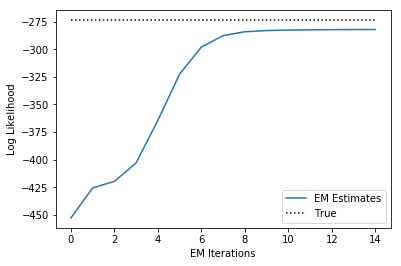

In [12]:
def emID(Phi,H,Q,R,x0_pre,P0_pre,Y,NumEMSteps):
    
    LL = []
    for step in range(NumEMSteps):
        Phi,H,Q,R,x0_pre,P0_pre,logLik = \
        emStep(Phi,H,Q,R,x0_pre,P0_pre,Y)
        
        LL.append(logLik)
        
    
    return Phi,H,Q,R,x0_pre,P0_pre,np.array(LL)

NumEMSteps =15
Phi_EM,H_EM,Q_EM,R_EM,x0_pre_EM,P_pre_EM,LL = emID(Phi_0,H_0,
                                                   Q_0,R_0,
                                                   xhat0_prior_0,P0_prior_0,
                                                   Y,NumEMSteps)

Questions[4].checkAnswer(LL)






# Final Score

You can run this code to see all of your scores.




In [13]:
Assignment.showResults()

Problem 0: 1
Problem 1: 1
Problem 2: 1
Problem 3: 1
Problem 4: 1

Total: 5 / 5





# Submission

Save your work and run this cell to submit. It will only work if you have the internet.

